In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
library('IRdisplay')
if (!require(tidyverse)) install.packages("tidyverse")
library('tidyverse')

n_cores <- detectCores()
cluster <- makeCluster(24) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
source('Rfiles/3m_comparison.R')
clusterExport(cluster, "expo_gen_2stages")

# 3 Methods Comparison Under Proportional Hazard

### 2 stages Rejection region of overall:
### 1. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>c_1\ \&\ \frac{W}{\sigma}>c}$
### 2. Simple RMST Difference
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
### 3. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$
--------

#### <span style="color:yellow"> Setting in Jung's 2017 table 1 first row:
#### We set the total accrual time = 2 years and follow up 1 year
#### Recruit rate is 60(30 per arm) per year calculate the test power of 3 method controling $\alpha = 0.05$
#### <span style="color:yellow">We can only compare Minimax design since the default rule is searching for maximum stage I power


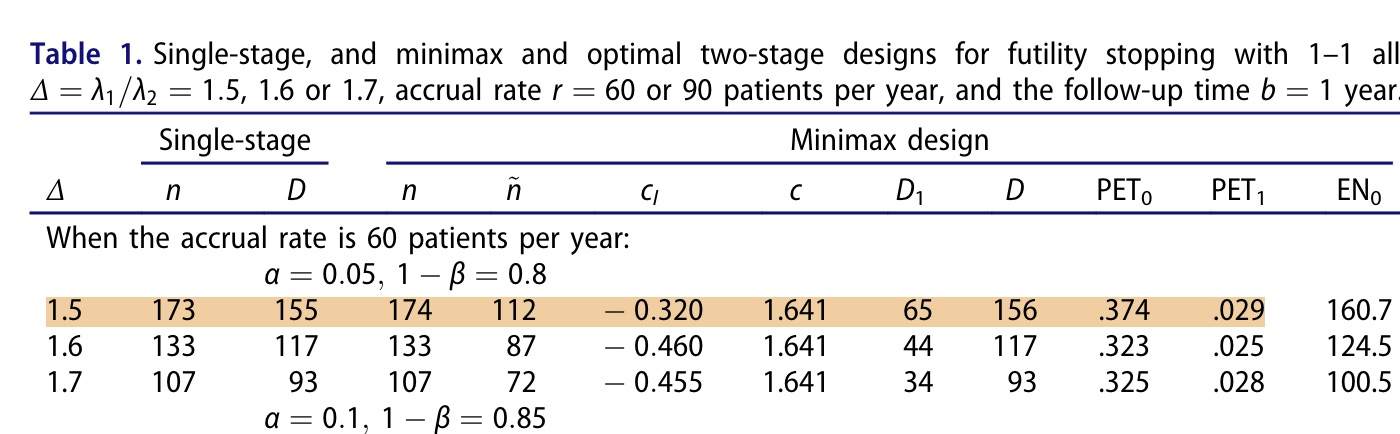

In [21]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

In [4]:
sim_size <- 5000
acc_time <- 174 / 60
cen_time <- 1
delta <- 1.5
lambda_H1 <- 0.9
lambda_H0 <- 0.9 * delta
r <- 60  # patient recruit rate
interim <- 2
n <- 174 / 2  # total sample size per arm
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)                    
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)

rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
#Log rank
z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], 
                                data_E = data_E_H0[ , c(2,3,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], 
                                data_E = data_E_H1[ , c(2,3,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], 
                                data_E = data_E_H0[ , c(4,5,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C[ , c(4,5,1)], 
                                data_E = data_E_H1[ , c(4,5,1)], sim_size =  sim_size,
                            n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

#Grid search critical value
search_times <- 500
#RMST
m_low <- 0
# Smallest RMST difference: interim under H0
m_up <- quantile((rmst_data[8,] - rmst_data[7,]), 0.9)
# Largest RMST difference: final under H1
search_step_rmst <- (m_up - m_low) / search_times
t_low <- quantile((rmst_data[2,]), 0.1)
# Smallest experiment RMST: interim under H0
t_up <- quantile((rmst_data[8,]), 0.9)
#Log rank
c_low <- quantile(logrank_data, 0.2)
c_up <- quantile(logrank_data, 0.8)
search_step_lr <- (c_up - c_low) / search_times

# Control PET0 and PET1
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0.1  # lower bound of 1-PET1
tar_alpha <- 0.05

best_our_rmst <- find_m_t_RMST(m_low = m_low, t_low = t_low, t_up = t_up, rmst_data = rmst_data, 
                            search_times = search_times, search_step = search_step_rmst, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

best_simple_rmst <- find_m_t_RMST(m_low = m_low, t_low = -Inf, t_up = t_up, rmst_data = rmst_data, 
                            search_times = search_times, search_step = search_step_rmst, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

best_log_rank <- find_m_logrank(m_low = c_low, logrank_data = logrank_data, 
                            search_times = search_times, search_step = search_step_lr, tar_a1 = tar_a1, 
                            tar_pow1_low = tar_pow1_low, tar_a2 = tar_alpha, sim_size = sim_size)

list(best_our_rmst = best_our_rmst, 
    best_simple_rmst = best_simple_rmst,
    best_log_rank = best_log_rank)

$best_our_rmst
              m1        t1   PET0   PET1           m2        t2  alpha  Power
90% 0.0009380478 0.5591242 0.5002 0.0498 0.0009380478 0.8410432 0.0494 0.9264

$best_simple_rmst
              m1   t1   PET0   PET1        m2   t2  alpha Power
90% 0.0009380478 -Inf 0.4914 0.0498 0.1669725 -Inf 0.0496 0.845

$best_log_rank
            m1   PET0   PET1       m2  alpha  Power
20% -0.2737572 0.3856 0.0236 1.642696 0.0494 0.7956

<span style="color:yellow">I pack all above up as a function to compare the result of 3 methods(3m_comparison.R)

## <span style="color:yellow">Grid search under a fixed interim period remarks:
### The searching range should be consistant under a specific experiment setting
###  1. Searching range of m (RMST difference):
#### $\qquad$ Lower bound is $\textcolor{lightgreen}{0}$ since we need to a superiority test
#### Upper bound larger than $E_2 - C_2|H_1$
#### $\qquad$ upper bound is controled by m_low + search_times * search_step
### 2. Searching range of t (RMST of experiment group):
#### $\qquad$ t_low slightly smaller than $E_1\ $; t_up slightly larger than $E_2$
#### $\qquad$ search_step of t = (upper - lower) / searching times
### 3. Searching range of c (critical value of Log rank):
#### $\qquad$ Lower bound slightly smaller than $\frac{W_1}{\sigma_1}|H_0\ $; Upper bound larger than $\frac{W}{\sigma}|H_1$
### · <font color=LightSeaGreen>Search for the highest power for both stage
### Once the search_times is set, the running time is fixed. 

-----

# Differnent scenario 
#### <font color=yellow>Remarks: function 3m_comparison contains cocurrent foreach loop. 


## 1.  Different Hazard Ratio
### $\lambda_E = 0.83 = log(2)*12/10$. Median event time is around 10 months

In [3]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
#grid search para__________
search_times <- 500
tar_a1 <- 0.8      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_delta <- foreach(delta = seq(1.2, 2, by = 0.1), .combine = rbind)%do%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(delta, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

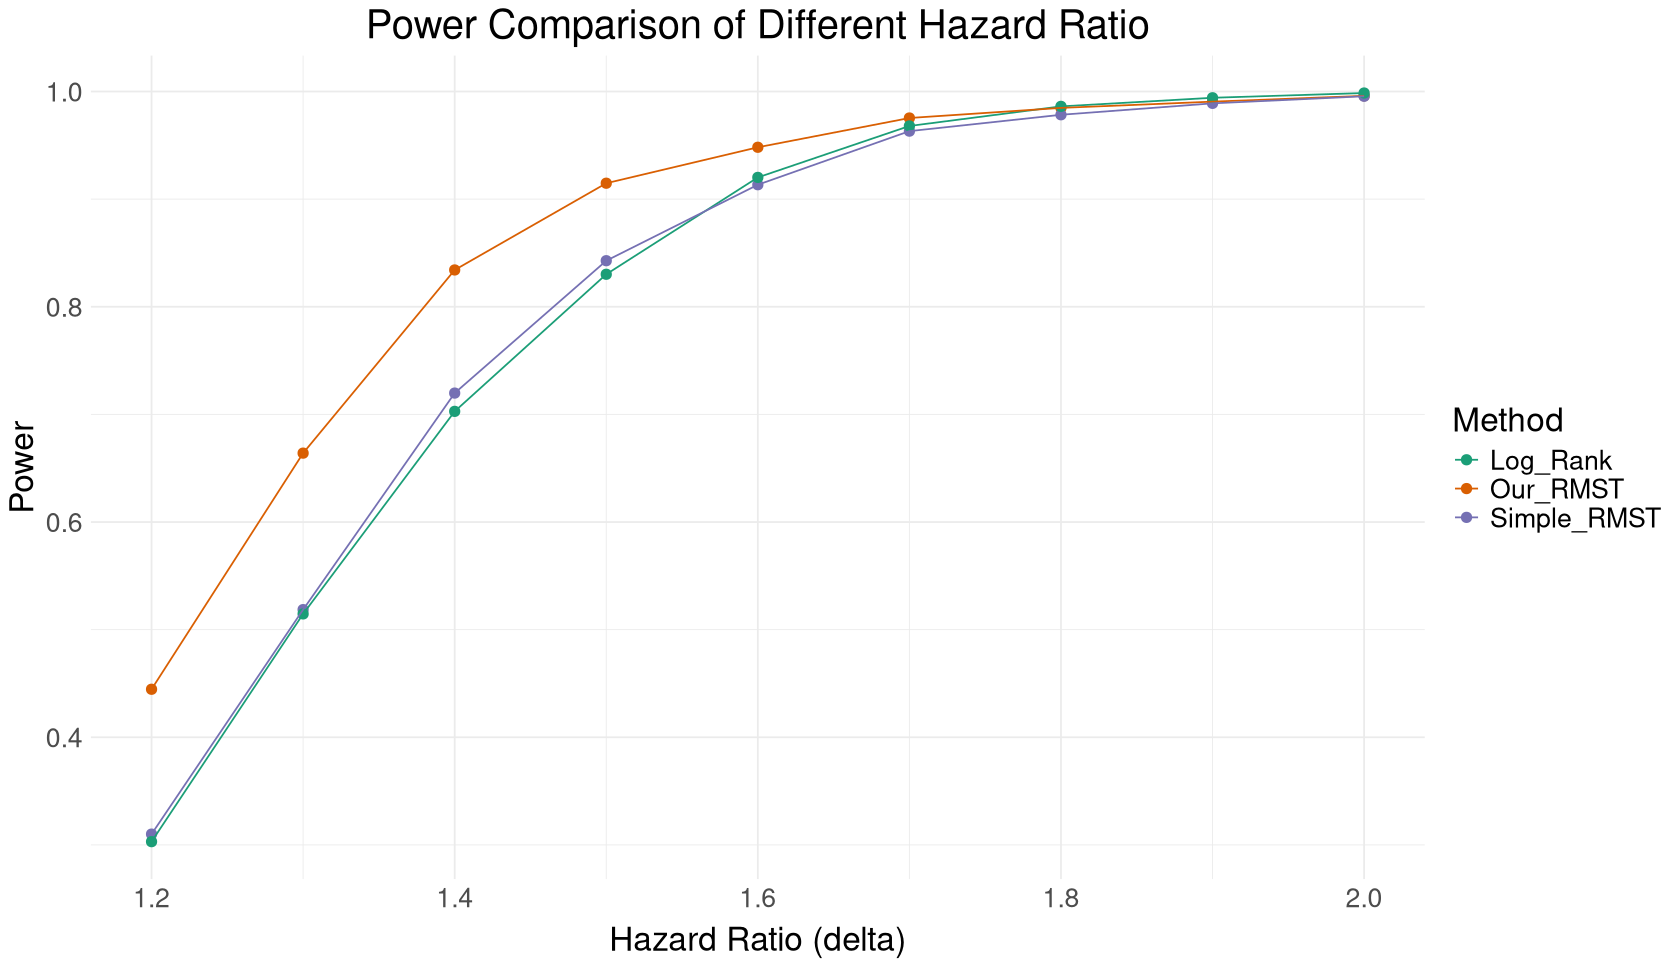

In [4]:
diff_delta <- data.frame(diff_delta)
colnames(diff_delta) <- c('Delta','Our_RMST','Simple_RMST','Log_Rank')
save(diff_delta, file = '/home/r27user6/RMST_Code/RData/diff_delta.RData')
load('/home/r27user6/RMST_Code/RData/diff_delta.RData')

diff_delta_long <- diff_delta %>% gather(key = "Method", value = "Power", -Delta)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_delta_long, aes(x = Delta, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison of Different Hazard Ratio",
    x = "Hazard Ratio (delta)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

-----
## 2. Different interim period
### Interim period from 40% to 90% of the whole accrual period

In [5]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.8      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_interim <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %do%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(int_sam, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

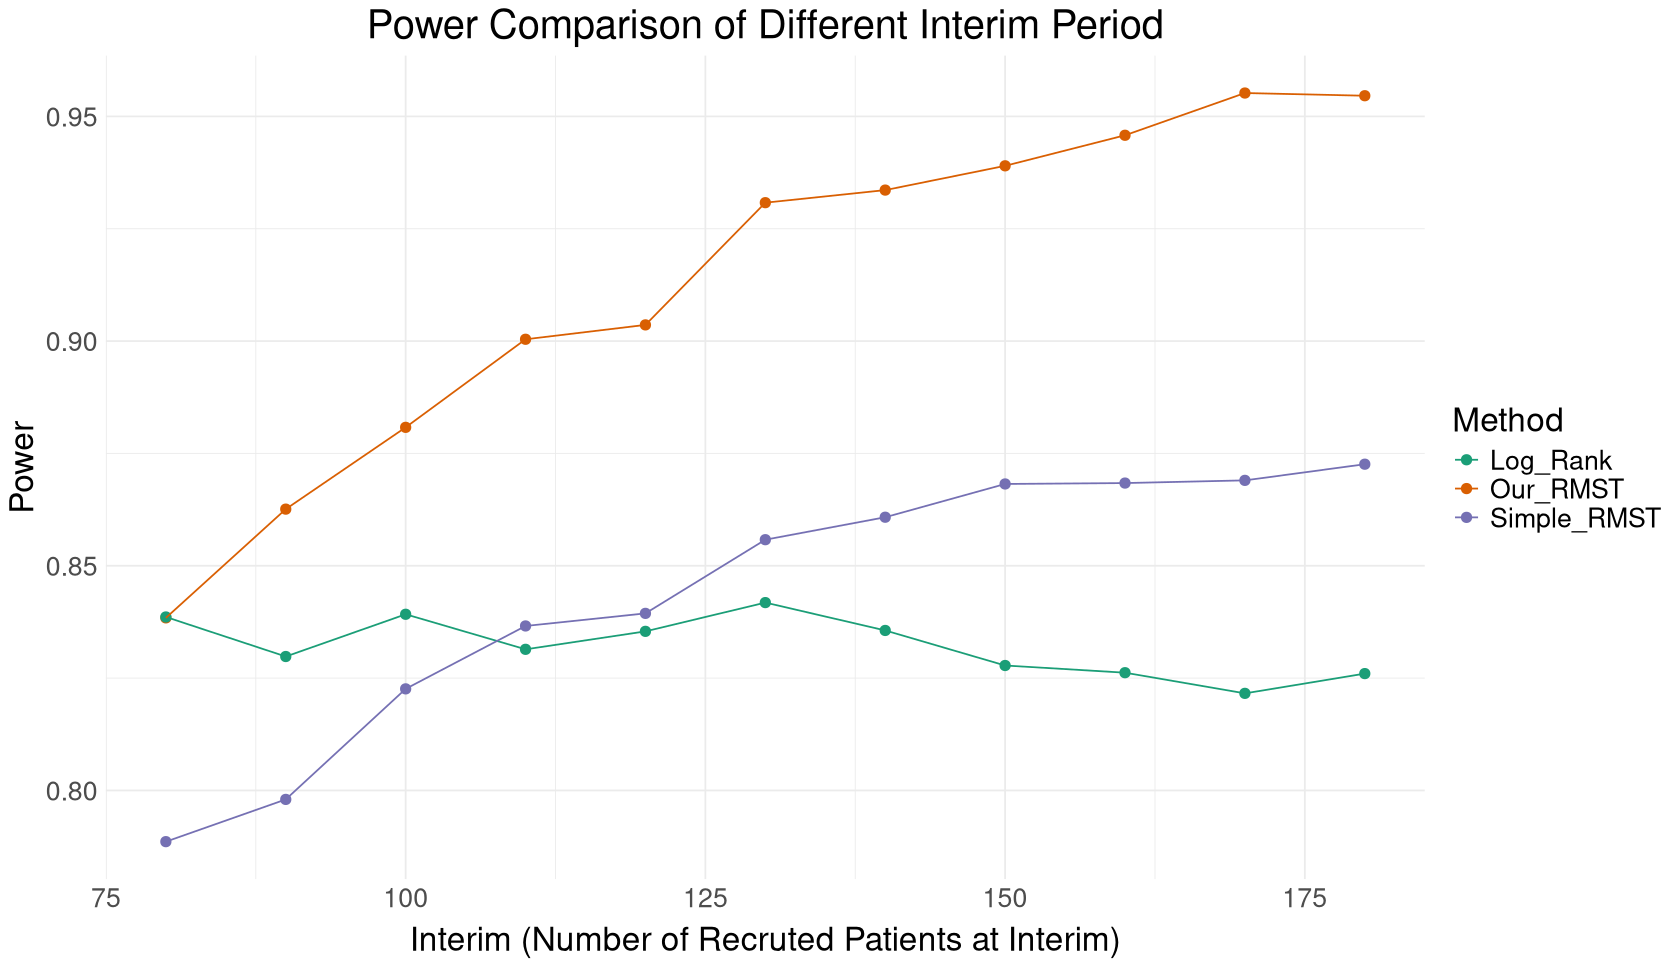

In [6]:
diff_interim <- data.frame(diff_interim)
colnames(diff_interim) <- c('Interim','Our_RMST','Simple_RMST','Log_Rank')
save(diff_interim, file = '/home/r27user6/RMST_Code/RData/diff_interim.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim.RData')

diff_interim_long <- diff_interim %>% gather(key = "Method", value = "Power", -Interim)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_interim_long, aes(x = Interim, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison of Different Interim Period",
    x = "Interim (Number of Recruted Patients at Interim)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.8      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_rec_rate <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(r, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

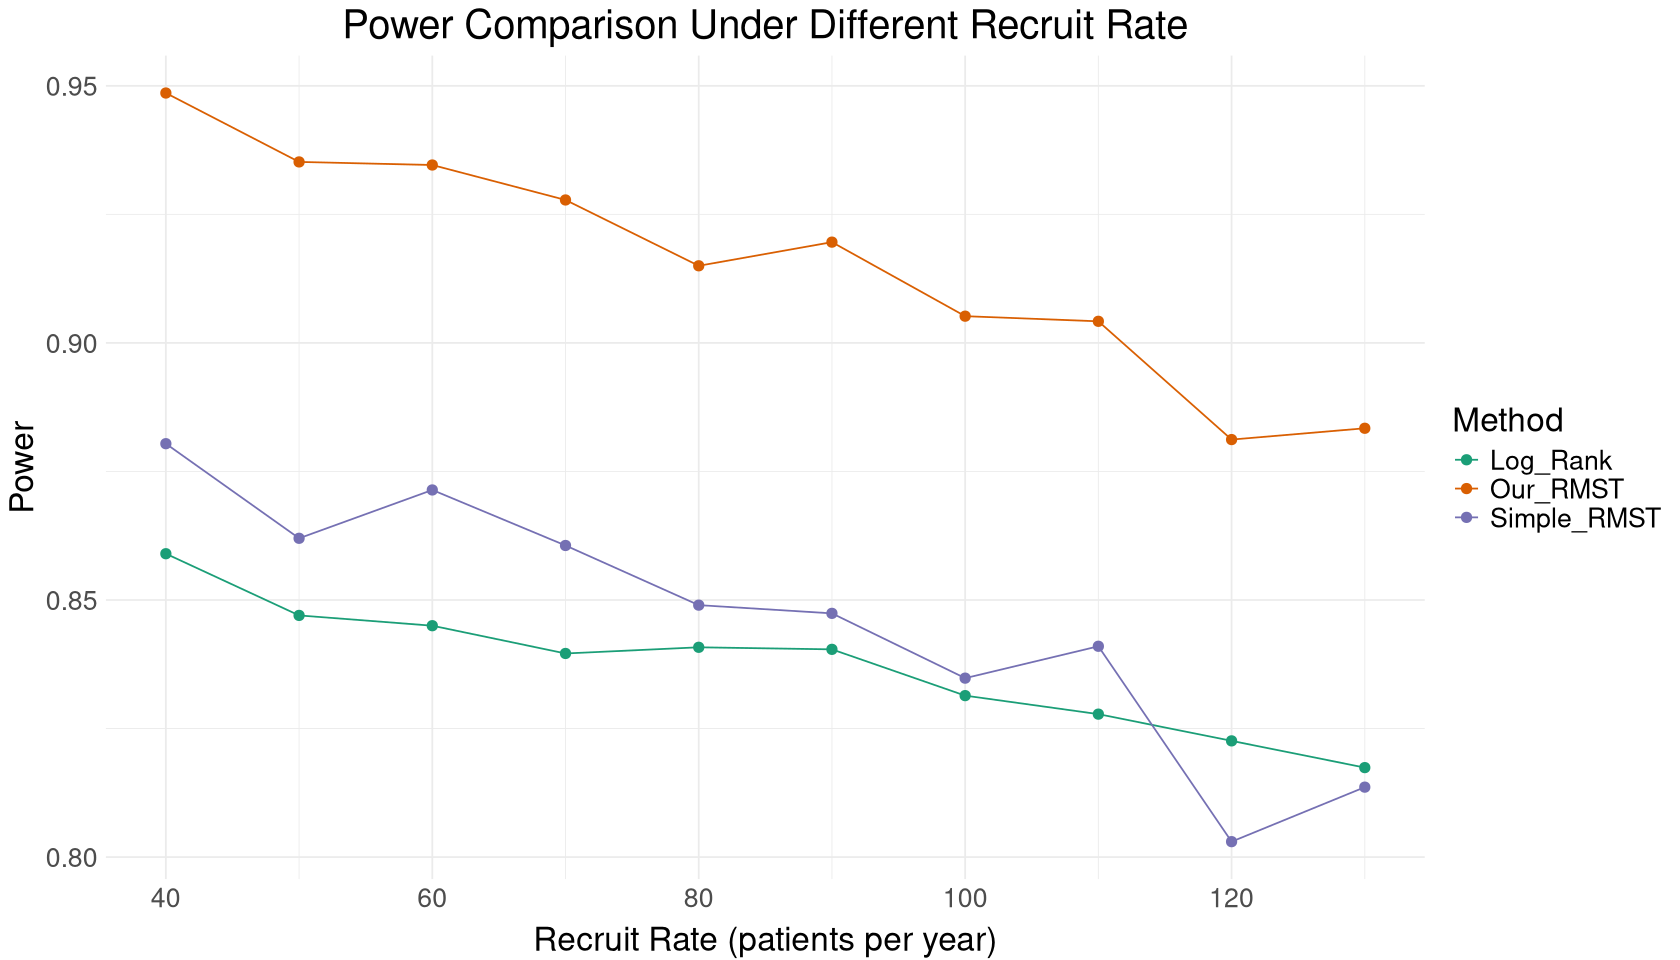

In [8]:
diff_rec_rate <- data.frame(diff_rec_rate)
colnames(diff_rec_rate) <- c('Recruit_rate','Our_RMST','Simple_RMST','Log_Rank')
save(diff_rec_rate, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')

diff_rec_rate_long <- diff_rec_rate %>% gather(key = "Method", value = "Power", -Recruit_rate)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_rec_rate_long, aes(x = Recruit_rate, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Recruit Rate",
    x = "Recruit Rate (patients per year)",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

------
## 4. Different $\lambda_E$
### Fix the hazard ratio, try different $\lambda$ of experiment group

In [12]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
cen_time <- 1
delta <- 1.5
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_lamb_e <- foreach(lambda_H1 = seq(0.5, 1, by = 0.05), .combine = rbind) %do%
    {
        lambda_H0 <- lambda_H1 * delta
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(lambda_H1, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

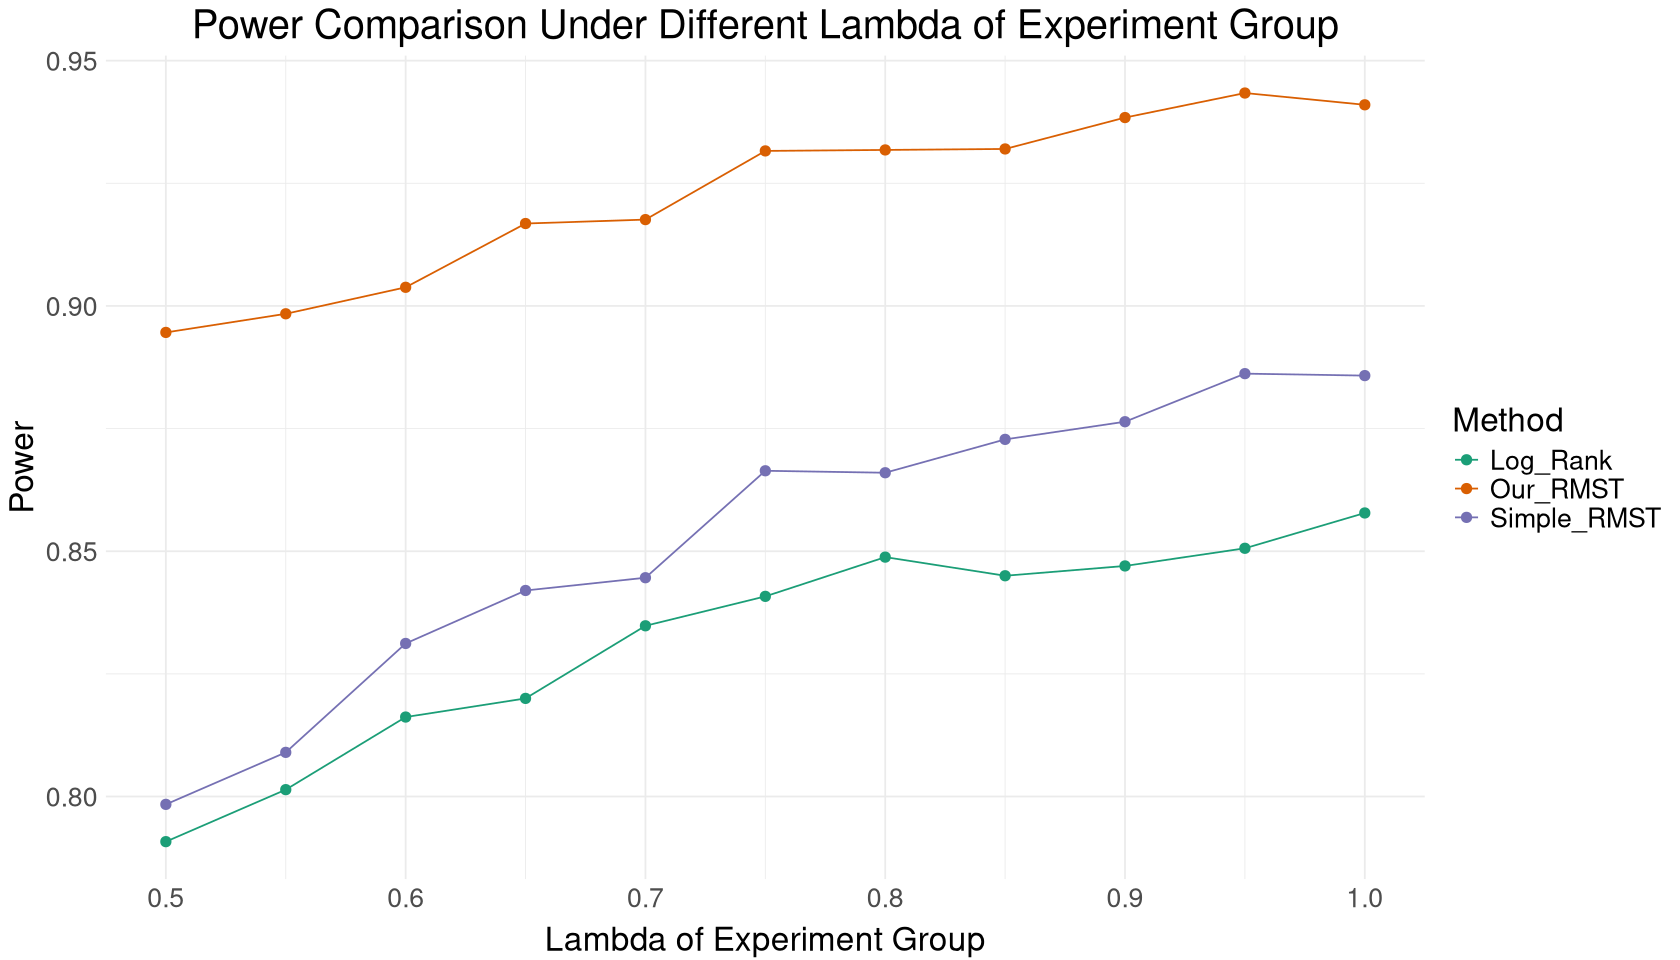

In [13]:
diff_lamb_e <- data.frame(diff_lamb_e)
colnames(diff_lamb_e) <- c('lambda_e','Our_RMST','Simple_RMST','Log_Rank')
save(diff_lamb_e, file = '/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')
load('/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')

diff_lamb_e_long <- diff_lamb_e %>% gather(key = "Method", value = "Power", -lambda_e)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_lamb_e_long, aes(x = lambda_e, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Lambda of Experiment Group",
    x = "Lambda of Experiment Group",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [14]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_a1 <- 0.65      #Upper bound of 1-PET0
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_cen <- foreach(cen_time = seq(0.6, 1.6, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(cen_time, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

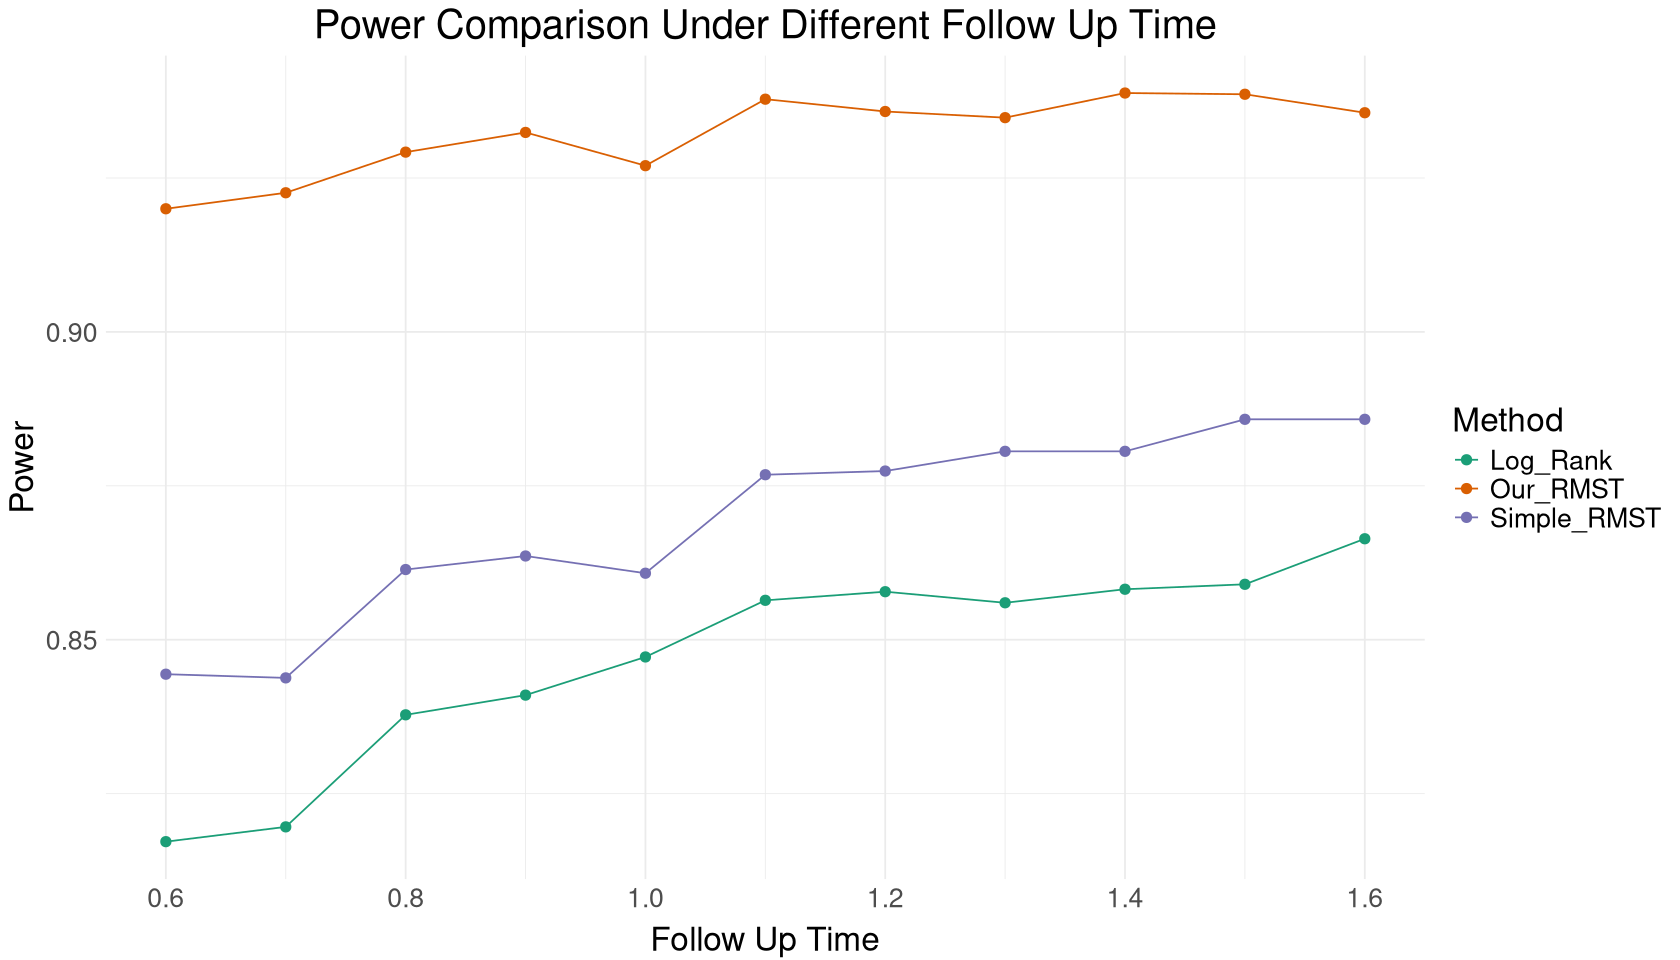

In [15]:
diff_cen <- data.frame(diff_cen)
colnames(diff_cen) <- c('cen_time','Our_RMST','Simple_RMST','Log_Rank')
save(diff_cen, file = '/home/r27user6/RMST_Code/RData/diff_cen.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen.RData')

diff_cen_long <- diff_cen %>% gather(key = "Method", value = "Power", -cen_time)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_cen_long, aes(x = cen_time, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Different Follow Up Time",
    x = "Follow Up Time",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

------
## 6. Different PET0 (1 - $\alpha_1$)
### We search for the most powerful paramter under each setting. So PET0 need to be controled.
### We control PET0 from 0.1 to 0.6 by 0.05

In [16]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 60
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
#grid search para__________
search_times <- 500
tar_pow1_low <- 0  # lower bound of 1-PET1
tar_alpha <- 0.05

diff_pet0 <- foreach(tar_a1 = seq(0.5, 0.9, by = 0.05), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                search_times = search_times, tar_a1 = tar_a1, tar_pow1_low = tar_pow1_low, tar_alpha = tar_alpha)
        c(1-tar_a1, result$best_our_rmst$Power, result$best_simple_rmst$Power, result$best_log_rank$Power)      
    }

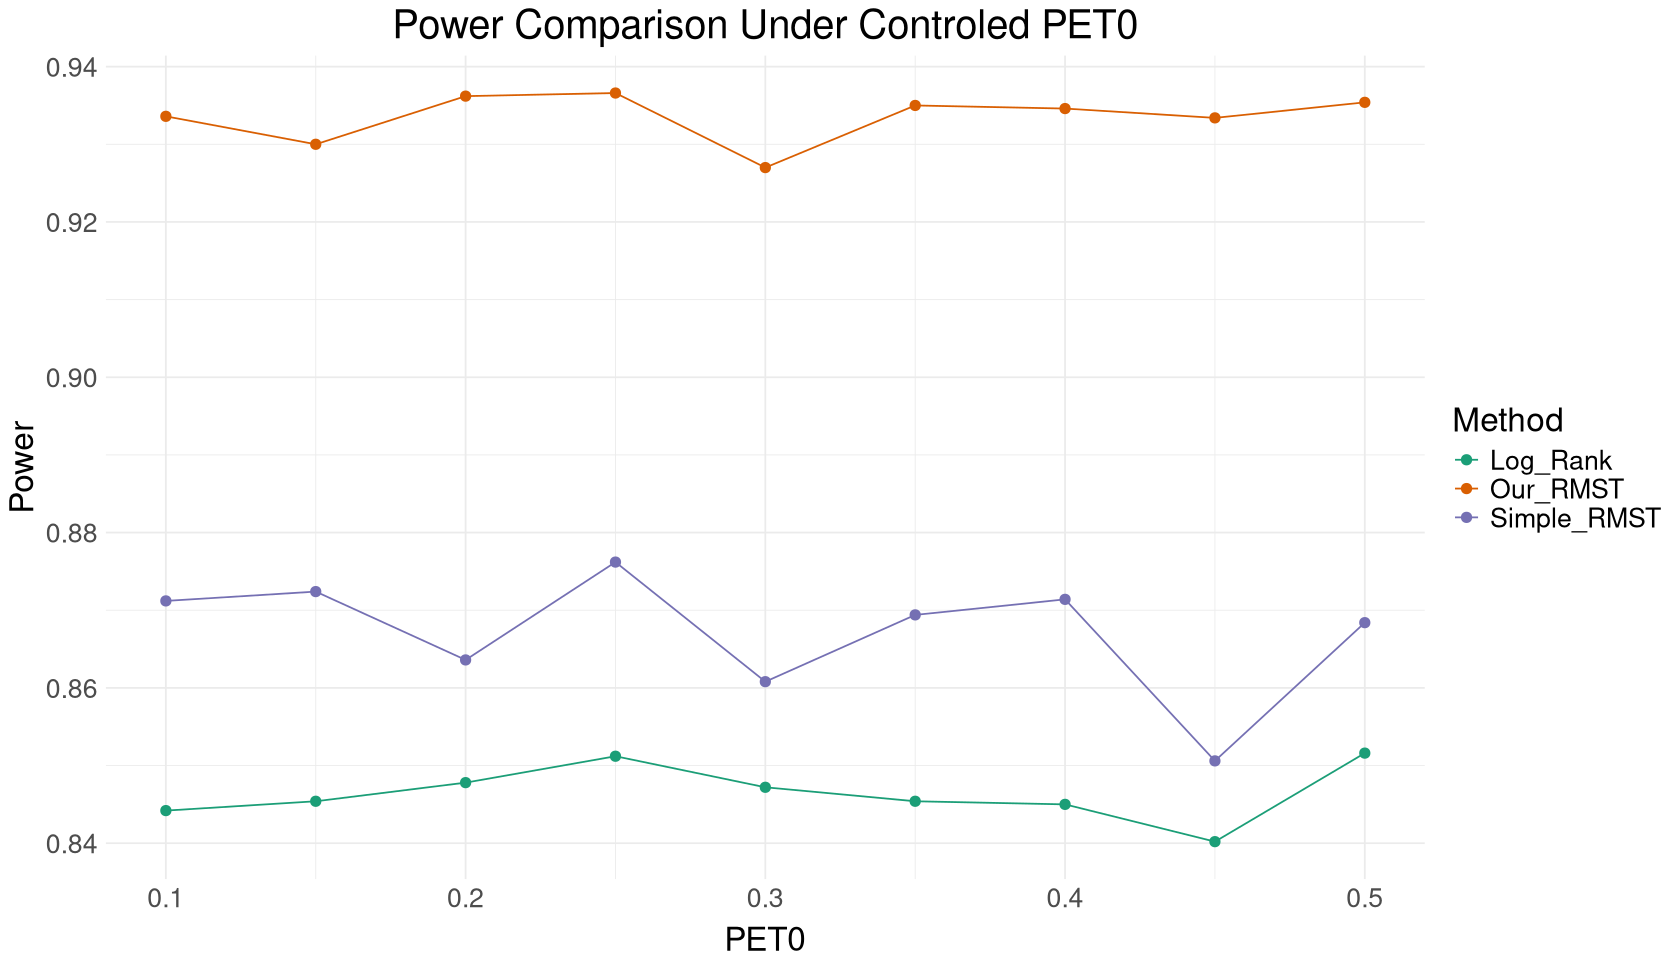

In [17]:
diff_pet0 <- data.frame(diff_pet0)
colnames(diff_pet0) <- c('PET0','Our_RMST','Simple_RMST','Log_Rank')
save(diff_pet0, file = '/home/r27user6/RMST_Code/RData/diff_pet0.RData')
load('/home/r27user6/RMST_Code/RData/diff_pet0.RData')

diff_pet0_long <- diff_pet0 %>% gather(key = "Method", value = "Power", -PET0)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(diff_pet0_long, aes(x = PET0, y = Power, color = Method)) +
  geom_point(size = 2.5) +
  geom_line() +
  scale_color_brewer(palette = "Dark2") +
  theme_minimal() +
  labs(
    color = "Method",
    title = "Power Comparison Under Controled PET0",
    x = "PET0",
    y = "Power"
  ) +
  theme(text = element_text(size = 20),
        axis.title.x = element_text(vjust = 0),
        axis.title.y = element_text(vjust = 1),
        plot.title = element_text(hjust = 0.5))

-----
# Optimal design search 

In [5]:
set.seed(2024)
sim_size <- 5000
n_low <- ceiling(0.8 * 174 / 2)  #log rank minimax
n_up <- ceiling (1.2 * 187 / 2)  # log rank optimal
n_list <- seq(from = n_low, to = n_up, by = 1)

r <- 60
cen_time <- 1
lambda_H1 <- 0.9
delta <- 1.5
lambda_H0 <- lambda_H1 * delta

dataset_tab1_row1 <- foreach(n = n_list, .combine = 'cbind') %dopar% 
  {
    acc_time <- n * 2 / r
    interim_sam_list <- seq(from = ceiling(0.5 * n), to = ceiling(0.8 * n), by = 2)  #interim sample size
    interim_list <- interim_sam_list * 2 / r
    inner_results <- array(NA,dim = c(8, sim_size, length(interim_list)))

    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim_list)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim_list) 
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim_list)         
  # Interim
    for (i in 1:length(interim_list)) 
      {
        interim <- interim_list[i]
        int_sam <- interim_sam_list[i]
        rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1), i], 
                                data_C = data_C[ , c(2,3,1), i], tau = interim, sim_size = sim_size)
        rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1), i], 
                                data_C = data_C[ , c(2,3,1), i], tau = interim, sim_size = sim_size)
        rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1), i], 
                                data_C = data_C[ , c(4,5,1), i],tau = acc_time + cen_time,sim_size = sim_size)
        rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1), i], 
                                data_C = data_C[ , c(4,5,1), i],tau = acc_time + cen_time,sim_size = sim_size)
        rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
        inner_results[, , i] <- rmst_data
      }

  list(int_sam = interim_sam_list, data = inner_results)
}



#### These data files are too large to be uploaded to Github

In [7]:
save(dataset_tab1_row1, file = '/home/r27user6/RMST_Code/RData/dataset_tab1_row1.RData')